# Recommending Top-N movies - Part 1: Introduction, timings and use cases

The MovieLens dataset, made by GroupLens, contains movies, tags, genres, and user ratings from real users, contributed voluntarily and gathered over various timeframes. GroupLens offer various version of the data set; this project uses the full 27M dataset which is open and free for educational and research purposes.

The aim of this project is to use the movie information and user ratings to build recommender systems using different approaches and algorithms. The algorithms are built with a focus on top-N recommendations and an end user application similar to Netflix where movies are shown on pages containing 5 movies per page. The algorithms will be able to take single movies, many movies, or a user's past ratings to achieve this.

The project comes in two parts. This first part gives an overview of the dataset and the algorithms, how the algorithms work, their use cases, and the various methods present in the objects used to access them contained in the associated python files. Part 2 takes a deeper dive into testing, comparing the accuracy of the algorithms using train-test-validation splits of the dataset, with a look at how the parameters coded into the algorithm affect the metrics used to test them. For further information on how each class works, see the documentation contained in MovieLensData.py, OneMovieCF.py, Algorithms.py, SplitData.py, and Tester.py.

------

## Importing and analysing the dataset

First, we import all the packages that will be used, and count the total amounts of data present in the set.

In [36]:
import importlib
import warnings
from time import perf_counter

import Algorithms
import MovieLensData
import OneMovieCF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.6f}'.format
sns.set()

In [2]:
ml = MovieLensData.MovieLensData()

totalUsers = len(ml.ratingsRaw['userId'].unique())
totalRatings = len(ml.ratingsRaw['userId'])
totalMovies = len(ml.moviesRaw['movieId'].unique())
totalMoviesRated = len(ml.ratingsRaw['movieId'].unique())

print("Total # of users:", totalUsers)
print("Total # of ratings:", totalRatings)
print("Total # of movies logged:", totalMovies)
print("Total # of movies rated:", totalMoviesRated)

Loading data... Done 
Total # of users: 283228
Total # of ratings: 27753444
Total # of movies logged: 58098
Total # of movies rated: 53889


Let's take a look at the structure of the two datasets we've imported.

In [3]:
display(ml.moviesRaw.head(5))
display(ml.ratingsRaw.head(5))

,movieId,title,year,genres
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II,1995,Comedy


,userId,movieId,rating,timestamp
0,1,307,3.500000,1256677221
1,1,481,3.500000,1256677456
2,1,1091,1.500000,1256677471
3,1,1257,4.500000,1256677460
4,1,1449,4.500000,1256677264


All 58098 movies and 283228 users have a unique integer ID associated with them. The titles and years for each movie are listed as strings. Genres are listed as pipe delimiter separated strings of which there are a total of 19 genres plus '(no genre listed)'.

The ratings from each user are listed by user ID and movie ID and a float representing their rating on a 0.5-5.0 scale in increments of 0.5. The timestamp column represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

The full dataset contains ratings for over 280K users with 27.7M ratings in total. These users have rated just under 54K movies, leaving just over 4K movies logged in the dataset with no ratings. Below is a plot the spread of ratings in the data.

Total # of unrated movies for every user: 16427226900


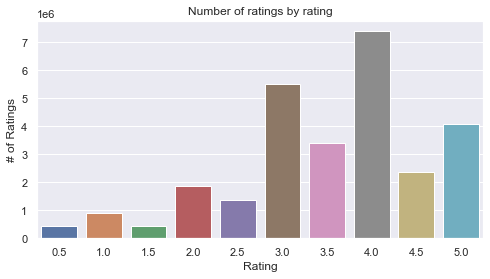

In [4]:
ratingCount = ml.ratingsRaw['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x=ratingCount.index, y=ratingCount.values)
ax.set(xlabel='Rating', ylabel='# of Ratings', title='Number of ratings by rating')

totalPossibleRatings = len(ml.ratingsRaw['userId'].unique()) * len(ml.moviesRaw['movieId'].unique())
unrated = totalPossibleRatings - len(ml.ratingsRaw['userId'])
print("Total # of unrated movies for every user:", unrated)

The most common ratings in order are 4.0, 3.0, and 5.0, indicating that users have a bias toward picking whole numbers for their ratings. We can also see that users are far less likely to give movies a 'perfect' 5.0 rating, preferring to give less-than-perfect 4.0 or 3.0 ratings. We can also see that users are very unlikely to rate movies anything below 3.0 showing a bias towards higher ratings.

Bias in user ratings is something we will have to consider as one user's 4.0 is not the same as another's i.e., 4.0 may be the highest rating for a harsh critic, but 4.0 could be a relatively low rating for a lenient critic. By plotting user rating means, we can get a sense of these biases present in the ratings.

Mean rating for all users: 3.5304452124932677


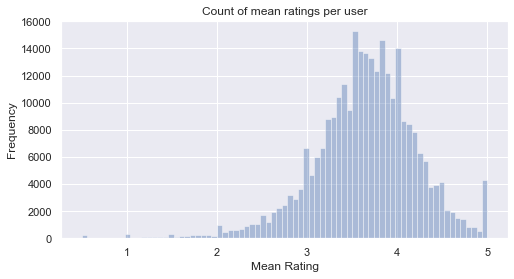

In [5]:
means = ml.ratingsRaw.drop(['timestamp', 'movieId'], axis=1).groupby('userId').mean().squeeze().rename('mean')

plt.figure(figsize=(8, 4))
ax = sns.distplot(means, bins=75, kde=False)
ax.set(xlabel='Mean Rating', ylabel='Frequency', title='Count of mean ratings per user')
print("Mean rating for all users:", ml.ratingsRaw['rating'].mean())

The mean rating for all users is around 3.5 with this plot of 75 bins, showing a mostly normal distribution peaking around 3.5-4.0. The key thing we see is the vast difference of mean ratings per each user. If user A, with a 2.0 mean rating, was found by an algorithm to be similar to user B, with a 4.0 mean rating, we could not simply just assign ratings from user B to user A without considering their mean ratings in some way. It will therefore be crucial to implement a consideration of rating bias in our recommender.

However, these outlier counts may just be from users with very low movie rating counts. We can plot movie counts against mean ratings to see how movie rating count affects their perceived bias.

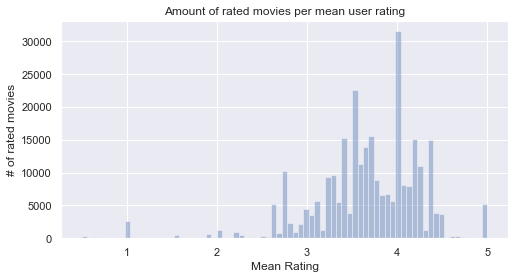

In [6]:
counts = means.reindex(ml.ratingsRaw['userId'].value_counts().rename('Len-Means'))

plt.figure(figsize=(8, 4))
ax = sns.distplot(counts, bins=75, kde=False)
ax.set(xlabel='Mean Rating', ylabel='# of rated movies', title='Amount of rated movies per mean user rating')
plt.show()

This graph shows mean ratings with each bar now weighted for the sum of the movies rated by all users with that mean rating. We see a clear preference for 4.0 and 3.5 ratings, with these being the average rating for some of the higher rating volume users. The outlier at 5.0 shows a small portion of users whose ratings consist solely of 5.0 ratings. This is also most likely true for those with mean ratings at 1.0 due to the low amount of data surrounding it. Disregarding these anomalies and other low count mean ratings, this leaves most of our higher volume users having biased ratings within the 2.5-4.5 range.

To gain a better understanding of the spread of user rating counts, we can plot the number of ratings per user. The graph follows a deeply exponential curve so it is therefore better visualised on a log graph.

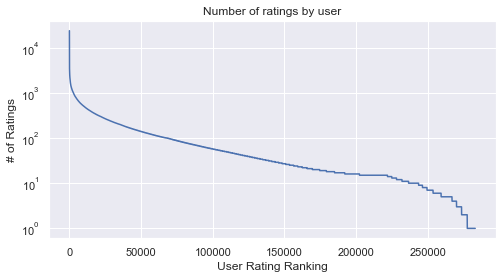

In [7]:
userRatingCount = ml.ratingsRaw['userId'].value_counts().reset_index(drop=True)

plt.figure(figsize=(8, 4))
ax = sns.lineplot(x=userRatingCount.index, y=userRatingCount.values)
ax.set(xlabel='User Rating Ranking', ylabel='# of Ratings', title='Number of ratings by user', yscale='log')
plt.show()

We can see a very small number of users (~<5000) with rating sizes between 1000 and 15000 ratings. These users will have great sway on our predictions, statically skewing recommendations to the movies they have rated highly. Due to this, it may be wise to disregard users with high sizes of ratings to stop their biases skewing recommendations.

We can also see a great number of users with very low rating sizes of ~<20. These users will be very hard to recommend movies for as there is not much data to go on. Such users may get recommendations widely unrelated to their tastes. Similarly, it may be that these users just have very niche tastes for films with very low ratings themselves. To check whether this is true, we can also look at the sizes of ratings per movie.

Total # of unrated movies: 4209


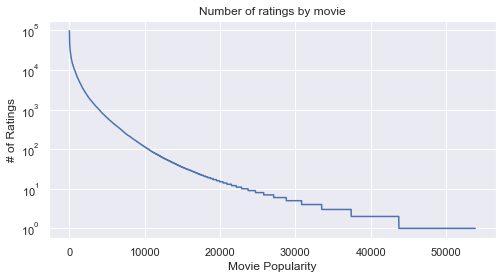

In [8]:
movieRatingCount = ml.ratingsRaw['movieId'].value_counts().reset_index(drop=True)

plt.figure(figsize=(8, 4))
ax = sns.lineplot(x=movieRatingCount.index, y=movieRatingCount.values)
ax.set(xlabel='Movie Popularity', ylabel='# of Ratings', title='Number of ratings by movie', yscale='log')

unratedMovies = totalMovies - len(ml.ratingsRaw['movieId'].unique())
print("Total # of unrated movies:", unratedMovies)

Over half of all rated movies have ~<10 ratings, showing a great deal of very niche movies in the database. Such movies will usually be missed by basic recommenders due to lack of correlation with other items. This 'long-tail' of items is a common problem in these algorithms with companies aiming to recommend as much of this content as possible, as this can be where the most profitable items lie due to profit margins. However, recommending too many of these items will lead to user distrust in the system, so it is a delicate balance to consider. We will measure this using the novelty metric in part 2 of this project.

Due to the large amount of data, lack of sophisticated systems available for this project, and potential issues that can arise from the issues discussed above, I will reduce the data for this project. While it will help the quality of recommendations for the purposes of testing, it goes without saying that real world data is, by nature, very sparse and as such, sophisticated recommenders should find ways to take both of these groups into consideration.

I will sample users with rating counts between 200 and 6000 to avoid biases from outliers. Similarly, I will limit the movies to those with more than 100 ratings.

In [3]:
userIDs = ml.filterIDs('userId', minRatings=200, maxRatings=6000)
movieIDs = ml.filterIDs('movieId', minRatings=100)
ml.reduce(userIDs, 'userId', 'ratings')
ml.reduce(movieIDs, 'movieId', 'movies')
ratingsData = ml.buildPivot(printStats=True)

Building movies/ratings pivot df... Done 
35281 / 283228 users retained (12.46%)
10500 / 58098 movies retained (18.07%)
16501295 / 27753444 ratings retained (59.46%)
95.55% sparsity


## Collaborative Filtering

- Similarities based on ratings, genre and year for single movie.
- Combining the above for better predictions.
- Generating correlation matrices for ratings, genre and year for all movies and combining.
- Generating correlation matrix for all users based on ratings and returning similar movies based on the ratings of the most similar users.

Collaborative Filtering algorithms aim to calculate the similarity or distance between items or users, and recommend based on a generated similarity matrix. Many methods can be used, such as simple matching coefficient, Jaccard index, or Euclidian distance. This algorithm will use cosine similarity, which represents all items/users as multi-dimensional vectors and calculates the angle between these vectors. It does this by taking the dot product of the two vectors divided by the product of the magnitude of the two vectors. Applying this to all items and users respectively will give us two matrices from which we can calculate similarities to an item or user.

The first step toward doing this is to build a pivot table of items against users (with missing data filled with nan) from the reduced ratings set built earlier.

In [10]:
sparsity = ratingsData.isnull().sum() * 100 / len(ratingsData)
print(round(sparsity.sum() / len(sparsity), 2), "% sparsity", sep='')
ratingsData

95.55% sparsity


movieId,1,2,3,4,5,6,7,8,9,10,...,188751,188797,189041,189203,189333,189363,189713,191351,191799,192283
userId,,,,,,,,,,,,,,,,,,,,,
4,4.000000,4.000000,NaN,NaN,2.000000,4.500000,NaN,NaN,NaN,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,4.000000,NaN,NaN,4.000000,NaN,NaN,4.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,4.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,4.000000,3.000000,4.000000,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283184,4.000000,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.500000,4.500000,NaN,NaN,NaN
283185,NaN,NaN,NaN,4.000000,NaN,NaN,3.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283195,5.000000,4.000000,4.500000,NaN,NaN,4.500000,NaN,NaN,NaN,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The sparsity is the percentage of nan values present in the data frame. A sparsity of around 95.5% is mostly normal, even a bit low, for these system with this kind of real-world data. With this table built, we can now start to recommend some movies.

### Single movie recommendations

- Correlating ratings using cosine similarity
- Correlating genres using cosine similarity
- Comparing release years using an exponential function
- Combining the above and limiting our results

To recommend movies based on a single movie, we can correlate this movie with the ratings in the pivot table to get the most similar movies to this one according to the cosine similarity formula. 

The OneMovieCF class initialises with a MovieLensData object and the information for the movie which we wish to recommend movies for. This initialisation returns the movieID for this movie by searching the moviesRaw data frame in the MovieLensData object.

The getSimilarMovies method then applies cosine similarity the pivot table by calling the corrwith function. This provides a series of movieIDs and their similarity to the correlating movieID. It then gets info about the movies from the moviesRaw data frame contained in the ml object including title, year, popularity etc. and presents this as a data frame.

In [11]:
movie = ["Lord of the Rings", 2001]
oneMovieCF = OneMovieCF.OneMovieCF(movie, ml)

ratings = oneMovieCF.getSimilarRatings()
ratings.head(10)

Initialising object... Done 
Finding recommendations for: Lord of the Rings: The Fellowship of the Ring, The (2001) - ID:[4993]
Correlating ratings... Done 


,title,year,popularity,rating#,ratingMean,genres,similarity
movieId,,,,,,,
5952,"Lord of the Rings: The Two Towers, The",2002,27,22168,4.041163,Adventure|Fantasy,0.871633
7153,"Lord of the Rings: The Return of the King, The",2003,39,20964,4.067902,Action|Adventure|Drama|Fantasy,0.869907
601,"Wooden Man's Bride, The (Yan shen)",1994,12390,51,2.892157,Drama,0.712344
889,1-900 (06),1994,12583,49,2.785714,Drama|Romance,0.662388
790,"Unforgettable Summer, An (Un été inoubliable)",1994,13059,44,3.000000,Drama,0.657260
108,Catwalk,1996,12393,51,2.852941,Documentary,0.652490
27163,Something Is Happening (Kuch Kuch Hota Hai),1998,11363,65,3.653846,Comedy|Musical|Romance,0.638907
114329,What We Did on Our Holiday,2014,9895,97,3.567010,Comedy,0.634830
98809,"Hobbit: An Unexpected Journey, The",2012,622,6396,3.563321,Adventure|Fantasy|IMAX,0.544402


As you may expect for 'The Fellowship of the Ring', two of the movies in the top 10 are simply the sequels showing that the correlation has worked to some degree. However, many of the films deemed most similar to this movie are far less expected. It could indicate that most users who like 'The Fellowship of the Ring' also have very niche tastes as most of these films have very low rating sizes of <100 whereas the two 'Lord of the Rings' sequels have rating sizes close to 20K. However, it's far more likely that simply correlating movies doesn't take into account the validity of the correlations i.e., how low amounts of data available for some movies negatively skew the similarity scores.  The genres of the films recommended further indicate this as all are either comedy or drama, whereas we may associate 'The Fellowship of the Ring' far more with the Adventure and Fantasy genres.

Given this, it may be worth considering how the genres of movies are correlated. To do this, we will need to represent these genres in a way the correlation function can understand. One way to achieve this is to represent the movies as a bit field. For example, if the database had only 4 genres (Action, Adventure, Drama and Fantasy), then 'The Return of the King' would have a bit field of 1111, whereas 'The Two Towers' would be 0101, and 'Wooden Man's Bride' would be 0010. By splitting up the string given in the genres column of the moviesRaw data frame contained in the ml object, we can build a bit field for all movies in the dataset. The buildGenreBitfield method from the ml object performs this.

In [12]:
ml.buildGenreBitfield()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,IMAX,Romance,Sci-Fi,Thriller,War,Western
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189363,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
189713,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
191351,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
191799,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


With the 19-bit bit field constructed, we can now perform the cosine similarity function, where each movie is now a 19-dimensional item to correlate. By accessing the bit field for 'The Fellowship of the Ring' and correlating this with all other movies in the bit field, we can generate similarities based on genre alone. The getSimilarGenres method from the OneMovieCF object does this.

In [13]:
print('The Fellowship of the Ring has genres:', ml.getInfo(4993, get='genres')[0])
genres = oneMovieCF.getSimilarGenres()
genres

The Fellowship of the Ring has genres: Adventure|Fantasy
Correlating genres... Done 


,title,year,popularity,rating#,ratingMean,genres,similarity
movieId,,,,,,,
152063,Gods of Egypt,2016,5246,453,2.655629,Adventure|Fantasy,1.000000
2140,"Dark Crystal, The",1982,748,5660,3.578357,Adventure|Fantasy,1.000000
3807,Sinbad and the Eye of the Tiger,1977,5603,393,3.174300,Adventure|Fantasy,1.000000
5974,"Thief of Bagdad, The",1940,6495,290,3.617241,Adventure|Fantasy,1.000000
6743,Jungle Book,1942,4422,623,3.477528,Adventure|Fantasy,1.000000
...,...,...,...,...,...,...,...
31660,Steamboy (Suchîmubôi),2004,4095,716,3.378492,Action|Animation|Drama|Sci-Fi,0.000000
4003,She's Having a Baby,1988,4096,716,2.843575,Comedy,0.000000
4082,Barfly,1987,4097,715,3.405594,Comedy|Drama|Romance,0.000000


As you would expect, the most similar movies have the exact same genre as the 'The Fellowship of the Ring' showing the correlation to have worked, but there are still a few movies with very low rating sizes that seem disconnected. We do see the least similar movies have genres completely different to the test movie, however all movies in the top 10 have the exact same similarity making it hard to tell the order in which movies are most similar to our test movie. 

We can also see a vast difference in years with some movies dating as far back as the 1940s. It may be highly unlikely that users who like modern adventure films will like movies released 60 years prior therefore, it could also be wise to consider the correlation between the years movies were released. To do this, we can calculate the absolute integer difference between release years and applying a function to this value to normalise it for the 0-1 range to keep it in line with our previous correlation scores. While we could apply a simple linear function to achieve this, we would ideally like movies released closer to the test movie to correlate far more highly than those released decades away. This can be achieved with an exponential function of negative power, in this case e^(-x/7) where x is the difference and e is Euler's number. The getSimilarYears method performs this for our test movie.

In [14]:
print('The Fellowship of the Ring was released in', ml.getInfo(4993, get='year')[0])
years = oneMovieCF.getSimilarYears()
years

The Fellowship of the Ring was released in 2001
Correlating years... Done 


,title,year,popularity,rating#,ratingMean,genres,similarity
movieId,,,,,,,
5268,No Such Thing,2001,8401,154,3.139610,Drama|Fantasy|Romance,1.000000
4168,Get Over It,2001,4891,516,2.944767,Comedy|Romance,1.000000
6400,Murder on a Sunday Morning (Un coupable idéal),2001,8188,164,3.731707,Documentary,1.000000
5134,Mean Machine,2001,5900,356,3.158708,Comedy|Drama,1.000000
170705,Band of Brothers,2001,3774,830,4.406024,Action|Drama|War,1.000000
...,...,...,...,...,...,...,...
8511,"Immigrant, The",1917,8690,141,3.645390,Comedy,0.000006
7243,Intolerance: Love's Struggle Throughout the Ages,1916,7291,215,3.602326,Drama,0.000005
7065,"Birth of a Nation, The",1915,5598,394,3.158629,Drama|War,0.000005


All movies in the top 10 were released in the same year as the test movie, with movies with the least similarity released nearly 100 years before the test movie, showing the function to have performed as expected. However, the most similar movies are just a random selection of movies released in 2001, with no consideration of genre or rating similarity to the test movie making this algorithm alone not a very good method for recommending movies.

Each of these three methods have their merits, but alone they wouldn't be sufficient for a very trust-worthy recommendation algorithm. But we can combine these methods to generate a list of movies from the best elements of each method. This can be achieved simply by multiplying each of their similarities together due to the fact that all similarities are normalised between 0-1. The getAll method achieves this.

In [15]:
top = oneMovieCF.getAll()
top.head(10)

,title,year,popularity,rating#,ratingMean,genres,similarity
movieId,,,,,,,
5952,"Lord of the Rings: The Two Towers, The",2002,27,22168,4.041163,Adventure|Fantasy,0.755599
7153,"Lord of the Rings: The Return of the King, The",2003,39,20964,4.067902,Action|Adventure|Drama|Fantasy,0.462247
64167,Dinotopia,2002,10035,94,2.936170,Adventure|Fantasy,0.316403
5816,Harry Potter and the Chamber of Secrets,2002,160,13731,3.528476,Adventure|Fantasy,0.289288
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,2001,110,15929,3.554398,Adventure|Children|Fantasy,0.270687
8368,Harry Potter and the Prisoner of Azkaban,2004,177,12976,3.688540,Adventure|Fantasy|IMAX,0.194374
6539,Pirates of the Caribbean: The Curse of the Bla...,2003,50,19702,3.742920,Action|Adventure|Comedy|Fantasy,0.191435
5618,Spirited Away (Sen to Chihiro no kamikakushi),2001,242,11086,4.137471,Adventure|Animation|Fantasy,0.191375
36289,Asterix & Obelix vs. Caesar (Astérix et Obélix...,1999,6558,285,2.933333,Adventure|Children|Comedy|Fantasy,0.184630


Many of these movies are good recommendations; we see the two sequels right at the top, the Harry Potter films and Pirates of the Caribbean. All these movies could be considered good recommendations for 'The Fellowship of the Ring'. However, some lesser-known films are still creeping into the top 10. One last fine-tune we can do is to limit the list to only those of a certain popularity or rating size.

In [16]:
top[top['rating#'] > 500].head(10)

,title,year,popularity,rating#,ratingMean,genres,similarity
movieId,,,,,,,
5952,"Lord of the Rings: The Two Towers, The",2002,27,22168,4.041163,Adventure|Fantasy,0.755599
7153,"Lord of the Rings: The Return of the King, The",2003,39,20964,4.067902,Action|Adventure|Drama|Fantasy,0.462247
5816,Harry Potter and the Chamber of Secrets,2002,160,13731,3.528476,Adventure|Fantasy,0.289288
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,2001,110,15929,3.554398,Adventure|Children|Fantasy,0.270687
8368,Harry Potter and the Prisoner of Azkaban,2004,177,12976,3.688540,Adventure|Fantasy|IMAX,0.194374
6539,Pirates of the Caribbean: The Curse of the Bla...,2003,50,19702,3.742920,Action|Adventure|Comedy|Fantasy,0.191435
5618,Spirited Away (Sen to Chihiro no kamikakushi),2001,242,11086,4.137471,Adventure|Animation|Fantasy,0.191375
4446,Final Fantasy: The Spirits Within,2001,784,5432,3.064433,Adventure|Animation|Fantasy|Sci-Fi,0.166423
4886,"Monsters, Inc.",2001,63,18294,3.804143,Adventure|Animation|Children|Comedy|Fantasy,0.162226


By limiting the movies to only those with more than 500 ratings, we get a fairly decent set of movie recommendations. All films seem believable and varied enough to recommend to a user who likes 'The Fellowship of the Ring'. However, it's worth noting that just because a movie has a low rating count does not mean it's niche. Such movies may have only been released recently and as such, not have had the same time to receive ratings as some older films have had. Therefore these newer movies will not have the same amount of data as movies like 'The Fellowship of the Ring' to produce accurate similarity scores. This is called the 'cold start' problem and is a common issue in recommender systems.

This dataset was generated on the 26/09/18 with ratings taken in various timeframes since 1995. If we were to run the same method on a movie released in 2018 while limiting the final results by rating size, this may cause it to show more dis-similar movies than we might hope for.

While this method does work, it would be very slow to do this on a movie-by-movie basis for a fast-loading recommendation system like Netflix. As such, a better approach would be to pre-generate similarity scores and store them for fast reference later when loading a page. We will look at this next.

### Item-based Collaborative Filtering

- All item similarity matrices using cosine similarity
- User-item CF
- Runtime comparisons
- Predicting ratings
- Limitations

Rather than correlating a given movie to the dataset in real time every time, we can instead generate a correlation matrix of all items using the corr function. This is the basis of Item-based Collaborative Filtering (CF). The code works in much the same way as before: generating cosine similarity scores for all items based on their ratings and genres, generating similarity scores by years by calculation with an exponential function, and multiplying the values for each item together to generate the similarity matrix. The buildModel(modelType='CF') method from the Algorithms class will build all of these for both items and users.

In [10]:
algo = Algorithms.Algorithms(ml)
CF_itemModel, CF_userModel = algo.buildModel(modelType='CF', printStatus=True)
CF_itemModel

Initialising object... Done 

Building CF model
Correlating ratings for all users... Done 
Correlating ratings for all movies... Done 
Correlating genres for all movies... Done 
Correlating years for all movies... Done 
Generating combined correlation... Done 
Done. Time: 103.81982679999999s


,1,2,3,4,5,6,7,8,9,10,...,188751,188797,189041,189203,189333,189363,189713,191351,191799,192283
1,1.000000,0.169168,0.019722,0.001834,0.046597,-0.014827,0.017393,0.031499,-0.004631,0.011535,...,0.000081,0.000024,0.000014,0.000020,0.000033,-0.000008,0.000031,0.000044,0.000003,0.000277
2,0.169168,1.000000,-0.025921,-0.011365,-0.018933,-0.008527,-0.018953,0.107835,-0.011012,0.047861,...,-0.000101,-0.000045,-0.000044,-0.000208,0.000211,-0.000247,-0.000038,-0.000120,-0.000093,-0.000073
3,0.019722,-0.025921,1.000000,0.140340,0.237111,-0.016042,0.269083,-0.016729,-0.015695,-0.026437,...,0.000016,-0.000033,0.000013,-0.000059,0.000019,-0.000012,-0.000064,-0.000433,-0.000009,0.000301
4,0.001834,-0.011365,0.140340,1.000000,0.113002,-0.008803,0.173194,-0.018851,-0.013597,-0.007917,...,0.000267,0.000016,-0.000024,-0.000021,0.000041,-0.000015,0.000072,-0.000162,0.000025,0.000236
5,0.046597,-0.018933,0.237111,0.113002,1.000000,-0.005196,0.207848,-0.014315,-0.009031,-0.014575,...,0.000090,-0.000158,-0.000002,-0.000042,-0.000014,0.000258,-0.000100,0.000032,-0.000022,0.000527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189363,-0.000008,-0.000247,-0.000012,-0.000015,0.000258,0.000107,0.000001,-0.000007,0.000015,-0.000166,...,0.051616,0.117306,0.093570,0.082016,0.141772,1.000000,0.071894,0.034035,-0.011730,0.108042
189713,0.000031,-0.000038,-0.000064,0.000072,-0.000100,0.000117,-0.000067,0.000016,-0.000021,0.000008,...,0.026642,0.053692,0.061344,0.003915,-0.037823,0.071894,1.000000,0.031240,-0.001379,0.117030
191351,0.000044,-0.000120,-0.000433,-0.000162,0.000032,0.000098,-0.000377,-0.000012,0.000028,0.000102,...,0.194120,0.025969,-0.004052,0.002272,-0.007427,0.034035,0.031240,1.000000,-0.001120,0.074615
191799,0.000003,-0.000093,-0.000009,0.000025,-0.000022,-0.000035,-0.000003,0.000005,-0.000055,0.000002,...,-0.002894,-0.007542,-0.009129,0.061442,-0.010949,-0.011730,-0.001379,-0.001120,1.000000,-0.000461


Here, we can see movie IDs along both rows and columns and how similar to every other movie in the reduced dataset. While this takes much longer to create initially, this will greatly reduce processing time when we look at recommending movies for a user. All we have to do to get similar movies to any movie now is to simply select the row or column of that movieID. This makes this a memory-based algorithm as all similarities are stored in memory for later accessing.

For this, we can user the getSimilarMovies method on 'The Fellowship of the Ring' once again.

In [13]:
oneMovieCF.similarRatings = None
oneMovieCF.similarGenres = None
oneMovieCF.similarYears = None
oneMovieCF.similarAll = None

t_start = perf_counter()
oneMovieCF.getAll()
print('\33[94;1m', "Time taken for one movie CF model: ", (perf_counter() - t_start), 's', '\33[0m', sep='')

t_start = perf_counter()
similarMovies = algo.getSimilarMovies(4993, CF_itemModel, 'CF', buildTable=True)
print('\33[94;1m', "Time taken for full item-based CF model: ", (perf_counter() - t_start), 's', '\33[0m', sep='')
similarMovies[:10]

Correlating ratings... Done 
Correlating genres... Done 
Correlating years... Done 
Time taken for one movie CF model: 11.096126999999967s
Time taken for full item-based CF model: 1.18186350000002s


,title,year,popularity,rating#,ratingMean,genres,similarity
movieId,,,,,,,
5952,"Lord of the Rings: The Two Towers, The",2002,27,22168,4.041163,Adventure|Fantasy,0.732148
7153,"Lord of the Rings: The Return of the King, The",2003,39,20964,4.067902,Action|Adventure|Drama|Fantasy,0.392064
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,2001,110,15929,3.554398,Adventure|Children|Fantasy,0.369148
5816,Harry Potter and the Chamber of Secrets,2002,160,13731,3.528476,Adventure|Fantasy,0.365934
6539,Pirates of the Caribbean: The Curse of the Bla...,2003,50,19702,3.742920,Action|Adventure|Comedy|Fantasy,0.270694
4886,"Monsters, Inc.",2001,63,18294,3.804143,Adventure|Animation|Children|Comedy|Fantasy,0.262571
4306,Shrek,2001,30,22033,3.727205,Adventure|Animation|Children|Comedy|Fantasy|Ro...,0.261270
5618,Spirited Away (Sen to Chihiro no kamikakushi),2001,242,11086,4.137471,Adventure|Animation|Fantasy,0.253471
8368,Harry Potter and the Prisoner of Azkaban,2004,177,12976,3.688540,Adventure|Fantasy|IMAX,0.211686


The movies returned are almost identical to the previous algorithm, with minor differences in similarity causing a different order to the ranking. The time taken for the single movie correlation object to perform a recommendation is close to 11s, whereas this new item-based CF model recommends in a milli-seconds, showing a great improvement on performance. We can now use this matrix to get user recommendations based upon the movies they have already rated. 

First, we'll add some movie ratings to the ratingsPivot data frame stored in the algo object. This user loves fantasy and action movies, but hates older musical movies.

In [11]:
mainRatings = {60684: 4, 77561: 3.5, 98809: 5, 165469: 1, 180263: 2, 914: 0.5, 899: 0.5, 85788: 4.5, 102445: 4.5,
               48774: 5}
algo.addTestUser(mainRatings)
algo.getUserRatings(0, buildTable=True)

User 0's ratings:


userId,title,year,rating
movieId,,,
899,Singin' in the Rain,1952,0.500000
914,My Fair Lady,1964,0.500000
48774,Children of Men,2006,5.000000
60684,Watchmen,2009,4.000000
77561,Iron Man 2,2010,3.500000
85788,Insidious,2010,4.500000
98809,"Hobbit: An Unexpected Journey, The",2012,5.000000
102445,Star Trek Into Darkness,2013,4.500000


The itemBased method picks out all the movies the user has rated from the item-based CF matrix generated earlier, and weights each of the similarities by multiplying each of the sets of similarities by the rating the user has given for that movie.

This method has two key parameters, neighbours and sample. The sample value limits the itemBased method to only looking at the top number of rated movies given by this parameter. The neighbours parameter is considered once passed to the getPredictedRatings method which sums similarities and predicts ratings from the weighted similarity matrix. Here, the neighbours value limits the ratings the amount of most similar movies to consider when summing similarities. It sums these limited similarities to produce a list of most similar movies to the user. 

To get the predicted ratings however, a sum of all unweighted similar movies is passed to the getPredictedRatings method with each weighted movie’s sum divided by this unweighted sum to provide some rating predictions. Finally, the user's bias is also considered for the predicted ratings by calculating the user's deviation from the mean of all ratings, and adding this to the rating predictions. To ensure this bias consideration doesn't cause the ratings to go above the maximum possible rating of 5, a limiting factor is place on the ratings. 

Both series are then passed to the buildTable function to add the extra information and display.

In [12]:
algo.itemBased(0, CF_itemModel, 'CF', buildTable=True, neighbours=10000000, printStatus=True)[:10]

Getting similar movies for all of user 0's rated movies... Done. Average time: 0.0002860999999967362s /rated movie
Weighting similarities by rating and predicting ratings... Done. Average time: 0.00274675000000002s /movie
Total Time: 0.018385199999983115s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
89745,"Avengers, The",2012,415,8331,3.688393,Action|Adventure|Sci-Fi|IMAX,0.841545,4.496305
68358,Star Trek,2009,365,8995,3.773708,Action|Adventure|Sci-Fi|IMAX,0.723829,4.420982
106489,"Hobbit: The Desolation of Smaug, The",2013,868,5009,3.512577,Adventure|Fantasy|IMAX,0.696480,4.930688
72998,Avatar,2009,223,11641,3.545658,Action|Adventure|Sci-Fi|IMAX,0.660116,4.398423
103042,Man of Steel,2013,1234,3642,3.086354,Action|Adventure|Fantasy|Sci-Fi|IMAX,0.658255,4.627255
96079,Skyfall,2012,656,6140,3.653094,Action|Adventure|Thriller|IMAX,0.646176,4.528516
95510,"Amazing Spider-Man, The",2012,1056,4185,3.209797,Action|Adventure|Sci-Fi|IMAX,0.646088,4.489509
110102,Captain America: The Winter Soldier,2014,887,4934,3.583705,Action|Adventure|Sci-Fi|IMAX,0.639432,4.528169
106487,The Hunger Games: Catching Fire,2013,785,5431,3.405358,Action|Adventure|Sci-Fi|IMAX,0.635906,4.564621


Given the makeup of our test user, these recommendations seem sensible. We can check to see the impact our algorithm has on recommendations by reversing this user's ratings and re-running.

In [13]:
oppositeRatings = {movie: 5.5 - ratings for movie, ratings in mainRatings.items()}
algo.addTestUser(oppositeRatings)
display(algo.getUserRatings(0, buildTable=True))
algo.itemBased(0, CF_itemModel, 'CF', neighbours=20, threshold=0, buildTable=True, printStatus=True)[:10]

User 0's ratings:


userId,title,year,rating
movieId,,,
899,Singin' in the Rain,1952,5.000000
914,My Fair Lady,1964,5.000000
48774,Children of Men,2006,0.500000
60684,Watchmen,2009,1.500000
77561,Iron Man 2,2010,2.000000
85788,Insidious,2010,1.000000
98809,"Hobbit: An Unexpected Journey, The",2012,0.500000
102445,Star Trek Into Darkness,2013,1.000000


Getting similar movies for all of user 0's rated movies... Done. Average time: 0.00023551249999798074s /rated movie
Weighting similarities by rating and predicting ratings... Done. Average time: 0.001084487500001785s /movie
Total Time: 0.010735500000009779s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
900,"American in Paris, An",1951,1823,2299,3.758373,Musical|Romance,0.314248,4.761637
89745,"Avengers, The",2012,415,8331,3.688393,Action|Adventure|Sci-Fi|IMAX,0.305592,0.998224
68358,Star Trek,2009,365,8995,3.773708,Action|Adventure|Sci-Fi|IMAX,0.304214,1.073557
1035,"Sound of Music, The",1965,290,10154,3.719076,Musical|Romance,0.263029,4.760422
1947,West Side Story,1961,658,6135,3.727954,Drama|Musical|Romance,0.244463,4.761468
95510,"Amazing Spider-Man, The",2012,1056,4185,3.209797,Action|Adventure|Sci-Fi|IMAX,0.241140,1.005012
79132,Inception,2010,171,13084,4.081435,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,0.237374,1.236675
72998,Avatar,2009,223,11641,3.545658,Action|Adventure|Sci-Fi|IMAX,0.232770,1.096188
102125,Iron Man 3,2013,838,5118,3.386479,Action|Sci-Fi|Thriller|IMAX,0.232303,1.151912


Some of these recommendations seem to make sense, however it seems the recommender is struggling to make suggestions for this inverted user. We see some more classic musical movies in our top 10, but it's still dominated by similar action films to those seen before, despite the algorithm thinking it will rate these movies as low as roughly 1.0. This is most likely due to this inverted user having only rated 2 musical number highly, with lots of low ranks for action films from which the algorithm is pulling information to fill the gaps despite their low ratings.

To combat this, a minimum threshold rating can be passed to the itemBased method to limit the ratings it considers. 

In [14]:
algo.itemBased(0, CF_itemModel, 'CF', neighbours=20, threshold=2.0, buildTable=True, printStatus=True)[:10]

Getting similar movies for all of user 0's rated movies... Done. Average time: 0.0006515000000035798s /rated movie
Weighting similarities by rating and predicting ratings... Done. Average time: 0.00227719999999465s /movie
Total Time: 0.006053400000013198s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
900,"American in Paris, An",1951,1823,2299,3.758373,Musical|Romance,0.314248,5.000000
1035,"Sound of Music, The",1965,290,10154,3.719076,Musical|Romance,0.263029,5.000000
1947,West Side Story,1961,658,6135,3.727954,Drama|Musical|Romance,0.244463,5.000000
2565,"King and I, The",1956,1593,2757,3.741748,Drama|Musical|Romance,0.225841,5.000000
3675,White Christmas,1954,2453,1587,3.729364,Comedy|Musical|Romance,0.204920,5.000000
915,Sabrina,1954,1241,3613,3.881954,Comedy|Romance,0.196691,5.000000
4356,Gentlemen Prefer Blondes,1953,2923,1226,3.656199,Comedy|Musical|Romance,0.196484,5.000000
916,Roman Holiday,1953,1034,4259,4.001174,Comedy|Drama|Romance,0.195292,5.000000
3549,Guys and Dolls,1955,2776,1330,3.710902,Comedy|Musical|Romance,0.179100,5.000000


Much better, though due to the fact the algorithm is only considering the two movies rated as 5.0, all our ratings our now 5.0. Issues of low rating predictions in the top recommended items can arise from users with very low rating counts, such as this test user, as the algorithm does not have enough data to gauge this users real interests.

### User-based Collaborative Filtering

- User-user CF
- Runtime comparisons
- Predicting ratings
- Limitations

We can also correlate this user directly with other users by weighting each similar users’ ratings to their similarity to the test user. Once each user is weighted, we also have to consider the similar users rating biases, calculating their deviation from the overall ratings mean and subtracting this from their similarity to the test user. Once this is done, the similarity matrix is passed to the getPredictedRatings to sum similarities and predict ratings as before.

Here, we're getting recommendations for our original test user who loves fantasy and action movies, but hates older musical movies.

In [15]:
algo.addTestUser(mainRatings)
algo.userBased(0, CF_userModel, 'CF', buildTable=True, printStatus=True)[:10]

Getting similar users for user 0... Done. Average time: 0.17141146099999985s /similar user
Weighting similarities by rating and predicting ratings... Done. Average time: 0.0011357680000000413s /similar user
Total Time: 17.255161799999996s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
2571,"Matrix, The",1999,2,28909,4.139092,Action|Sci-Fi|Thriller,1.000000,3.648420
2959,Fight Club,1999,17,24020,4.192756,Action|Crime|Drama|Thriller,0.992872,3.624073
4993,"Lord of the Rings: The Fellowship of the Ring,...",2001,18,23913,4.080479,Adventure|Fantasy,0.978020,3.573343
356,Forrest Gump,1994,1,29087,3.934627,Comedy|Drama|Romance|War,0.965979,3.532211
296,Pulp Fiction,1994,3,28120,4.218261,Comedy|Crime|Drama|Thriller,0.965021,3.528939
318,"Shawshank Redemption, The",1994,6,26627,4.373099,Crime|Drama,0.960466,3.513382
7153,"Lord of the Rings: The Return of the King, The",2003,39,20964,4.067902,Action|Adventure|Drama|Fantasy,0.933452,3.421108
5952,"Lord of the Rings: The Two Towers, The",2002,27,22168,4.041163,Adventure|Fantasy,0.912902,3.350913
58559,"Dark Knight, The",2008,131,14955,4.110966,Action|Crime|Drama|IMAX,0.872714,3.213640


As the algorithm now has to correlate this user with other users in real time, the runtime has now increased by a few orders of magnitude making this method less useful for fast access to recommendations. We can also see how different these movies are compared to the item-based recommender, with far fewer novel films appearing. A recommender like this may most likely not be great for a company as it doesn't access items in the long-tail, where the largest profit margins exist.

Most of these films are very popular films showing the algorithm is mostly just pulling the most popular movies from the similar user's ratings. To see the impact a user with more ratings has, let's test user 81.

In [17]:
userID = 81
print('User', userID, 'has rated', len(algo.getUserRatings(userID)), 'movies')
algo.userBased(userID, CF_userModel, 'CF', threshold=2, buildTable=True, printStatus=True)[:10]

User 81 has rated 1084 movies
Getting similar users for user 81... Done. Average time: 0.055756124000000115s /similar user
Weighting similarities by rating and predicting ratings... Done. Average time: 0.0010379910000000337s /similar user
Total Time: 5.679745400000002s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
5989,Catch Me If You Can,2002,93,16495,3.837011,Crime|Drama,0.766872,3.391588
1,Toy Story,1995,12,24644,3.846778,Adventure|Animation|Children|Comedy|Fantasy,0.760182,3.362904
150,Apollo 13,1995,55,19053,3.743374,Adventure|Drama|IMAX,0.690541,3.064304
68954,Up,2009,262,10620,3.896139,Adventure|Animation|Children|Drama,0.638594,2.841574
1266,Unforgiven,1992,252,10861,3.981585,Drama|Western,0.621078,2.766470
6870,Mystic River,2003,394,8567,3.792868,Crime|Drama|Mystery,0.614986,2.740347
1729,Jackie Brown,1997,316,9743,3.670635,Crime|Drama|Thriller,0.605947,2.701593
3114,Toy Story 2,1999,111,15907,3.755171,Adventure|Animation|Children|Comedy|Fantasy,0.602991,2.688916
8917,Team America: World Police,2004,775,5513,3.408036,Action|Adventure|Animation|Comedy,0.590941,2.637253


Here we see much less popular films appearing, however these films are still far more popular than those recommended by the item-based algorithm for the test user. This highlights the unpredictability of relying on user-based recommender system due to the vast differences in tastes user can have. Just because two users happen to rate movies similar, does not necessarily mean they have very similar tastes. Such algorithms are useful to consider, but should be tested rigorously as will happen in the next part of this project.

## K-Nearest Neighbours

K-Nearest Neighbours (KNN), like Collaborative Filtering, is a supervised machine learning algorithm, meaning it relies on labelled data to produce results. The labelled data in this case are the movies and their ratings for item-based methods, or users and their ratings for user-based methods. At a high-level, KNN works by assuming that similar things exist close to one another. In a basic 2-dimensional problem, one could imagine this on a scatter graph with various clear clusters of points. A KNN algorithm would attempt to identify the clusters, and label each point as being associated with that cluster. In contrast to CF, this is a model-based approach as we're querying a model to calculate similarities every time, rather than having all these values readily available in memory like in CF.

KNN algorithms come in two broad flavours, classification and regression. In classification problems, our data would be a clear binary of choices i.e., a movie was watched or not, whereas a regression problem contains a distribution of values to factor i.e., ratings for the watched movie. Hence we'll need a regression-based algorithm for our recommender.

Implementing all this from the ground up can be incredibly complex, so I'll be using sklearn's neighbours.NearestNeighbours. This algorithm simply takes a set of data and maps it out in such a way that we can pull the distance of its nearest k neighbours. These distances are our similarity, but are measured from 0 (the movie or user to pull similarities for) up to 1 (the furthest from the test item or user). We will therefore need to subtract these values to get a comparable similarity score to the CF algorithm above.

While we will be demonstrating the KNN algorithm, it's worth noting that a KNN algorithm is ill-advised for large datasets. This is due to the time it takes the algorithm to calculate distances in larger and sparse datasets. With sufficient resources, KNN could be a useful tool for a recommender system. However, we will see the runtime this algorithm has in comparison to CF.

### Item-Based KNN

- Building a sparse matrix
- Storing index-ID dictionaries
- Building the item-based model
- Runtime and limitations

One thing we can do to improve runtime is to create a sparse matrix from our ratings pivot data using SciPy's csr_matrix. This throws away any nan data present and just records the index positions of ratings. However, we cannot store the specific userIDs and movieIDs in the matrix and have to make a separate reference for which indices in the matrix are associated with what ID. The buildMatrix method accomplishes this.

In [18]:
ratingsSparse = algo.buildMatrix()
print(ratingsSparse[0, 0:20])
ratingsSparse

Building sparse matrix... Done 
  (0, 0)	4.0
  (0, 1)	4.0
  (0, 4)	2.0
  (0, 5)	4.5
  (0, 9)	4.0
  (0, 10)	3.5
  (0, 15)	4.0
  (0, 18)	2.0
  (0, 19)	2.5


<35281x10500 sparse matrix of type '<class 'numpy.float64'>'
	with 16501295 stored elements in Compressed Sparse Row format>

As we can see, the csr_matrix has dropped the indices relating to movies this user has not rated. This will speed up the KNN algorithm, but now we need to implement a way of switching between these indices and the IDs by using dictionaries. Let's now build our KNN model from this matrix and pull some recommendations for 'The Fellowship of the Ring'.

In [19]:
KNN_itemModel = algo.buildModel(modelType='KNN', matrix=ratingsSparse.transpose(), printStatus=True)

t_start = perf_counter()
similarMovies = algo.getSimilarMovies(4993, KNN_itemModel, 'KNN', neighbours=10, buildTable=True)
print('\33[94;1m', "Time taken for single movie KNN model: ", (perf_counter() - t_start), 's', '\33[0m', sep='')
similarMovies[:10]


Building KNN model
Done. Time: 1.7550529000000097s
Time taken for single movie KNN model: 0.376494799999989s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
5952,"Lord of the Rings: The Two Towers, The",2002,27,22168,4.041163,Adventure|Fantasy,0.939648,5.000000
7153,"Lord of the Rings: The Return of the King, The",2003,39,20964,4.067902,Action|Adventure|Drama|Fantasy,0.911833,4.851994
2571,"Matrix, The",1999,2,28909,4.139092,Action|Sci-Fi|Thriller,0.823207,4.380400
4306,Shrek,2001,30,22033,3.727205,Adventure|Animation|Children|Comedy|Fantasy|Ro...,0.813370,4.328056
6539,Pirates of the Caribbean: The Curse of the Bla...,2003,50,19702,3.742920,Action|Adventure|Comedy|Fantasy,0.805035,4.283704
5349,Spider-Man,2002,56,18998,3.465417,Action|Adventure|Sci-Fi|Thriller,0.786639,4.185820
3578,Gladiator,2000,25,22683,3.858572,Action|Adventure|Drama,0.784984,4.177011
2959,Fight Club,1999,17,24020,4.192756,Action|Crime|Drama|Thriller,0.781590,4.158951
5445,Minority Report,2002,65,18232,3.655057,Action|Crime|Mystery|Sci-Fi|Thriller,0.765415,4.072882


Slightly different, but still appropriate recommendations for our test movie. We can also see a 4x improvement on timings over the single item CF model. However, the issue of runtime comes with scalability as we'll see shortly. Let's check our regular test user once again.

In [20]:
algo.addTestUser(mainRatings)
algo.itemBased(0, KNN_itemModel, 'KNN', neighbours=100, buildTable=True, printStatus=True)[:10]

Getting similar movies for all of user 0's rated movies... Done. Average time: 0.3710902000000023s /rated movie
Weighting similarities by rating and predicting ratings... Done. Average time: 0.0009553000000011025s /movie
Total Time: 2.2324417000000096s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
79132,Inception,2010,171,13084,4.081435,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,1.000000,4.622090
91529,"Dark Knight Rises, The",2012,368,8917,3.844959,Action|Adventure|Crime|IMAX,0.984328,4.615975
59315,Iron Man,2008,193,12508,3.753718,Action|Adventure|Sci-Fi,0.913441,4.576869
58559,"Dark Knight, The",2008,131,14955,4.110966,Action|Crime|Drama|IMAX,0.900112,4.612066
68358,Star Trek,2009,365,8995,3.773708,Action|Adventure|Sci-Fi|IMAX,0.892209,4.596679
74458,Shutter Island,2010,356,9060,3.830795,Drama|Mystery|Thriller,0.878715,4.631900
72998,Avatar,2009,223,11641,3.545658,Action|Adventure|Sci-Fi|IMAX,0.871749,4.601819
71535,Zombieland,2009,479,7663,3.701488,Action|Comedy|Horror,0.870137,4.606038
70286,District 9,2009,308,9849,3.779318,Mystery|Sci-Fi|Thriller,0.861197,4.618593


Again, another set of good-looking recommendations for this user. We can now start to see some of the performance impacts with the KNN model, arising from the constant time it takes to look up the similarities for every movie the user has rated one by one. For this system, that figure is around 0.35s, and with user 0 having rated 8 movies, it takes just over 2s to pull recommendations. Let's see how the item-based KNN model takes a user with a greater number of ratings.

In [24]:
userID = 81
print('User', userID, 'has rated', len(algo.getUserRatings(1073)), 'movies')
algo.itemBased(userID, KNN_itemModel, 'KNN', neighbours=100, buildTable=True, printStatus=True)[:10]

User 81 has rated 1032 movies
Getting similar movies for all of user 81's rated movies... Done. Average time: 0.394707756495098s /rated movie
Weighting similarities by rating and predicting ratings... Done. Average time: 0.0006964776960783228s /movie
Total Time: 322.65013239999996s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
1,Toy Story,1995,12,24644,3.846778,Adventure|Animation|Children|Comedy|Fantasy,0.654470,3.807895
5989,Catch Me If You Can,2002,93,16495,3.837011,Crime|Drama,0.476964,3.715049
150,Apollo 13,1995,55,19053,3.743374,Adventure|Drama|IMAX,0.400261,3.758077
1197,"Princess Bride, The",1987,53,19284,4.099227,Action|Adventure|Comedy|Fantasy|Romance,0.336364,3.846854
68954,Up,2009,262,10620,3.896139,Adventure|Animation|Children|Drama,0.320243,3.838042
1573,Face/Off,1997,127,15045,3.250781,Action|Crime|Drama|Thriller,0.265422,3.652378
76251,Kick-Ass,2010,538,7165,3.587579,Action|Comedy,0.251073,3.829040
590,Dances with Wolves,1990,99,16188,3.639980,Adventure|Drama|Western,0.238113,3.697953
80463,"Social Network, The",2010,466,7756,3.708355,Drama,0.233420,3.951381


Here we can truly see the impracticalities of using KNN on a large data set. The algorithm follows O(n) complexity, increasing runtime linearly as the number of movies the user has rated, n, increases. However, we can improve timings by invoking the sample parameter once again which limits the amount of the movies the algorithm considers from the movies the user has rated. Such tests will be run in part 2.

### User-Based KNN

- Building the user-based model
- Runtime and appropriateness

One way the KNN algorithm still performs admirably is with user-based recommendations. As the algorithm only has to pull one set of similarities (the k most similar users), the runtime is greatly improved and less affected by the number of movies the test user has rated. Again, we get distances of 0-1 which must be inverted, biases and sums considered, with all this passed on to the getPredictedRatings method to produce our final recommendations.

In [21]:
KNN_userModel = algo.buildModel(modelType='KNN', matrix=ratingsSparse)
algo.userBased(81, KNN_userModel, 'KNN', neighbours=100, buildTable=True, printStatus=True)[:10]

Getting similar users for user 81... Done. Average time: 0.05950597600000009s /similar user
Weighting similarities by rating and predicting ratings... Done. Average time: 0.0010999609999998937s /similar user
Total Time: 6.061408099999994s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
1,Toy Story,1995,12,24644,3.846778,Adventure|Animation|Children|Comedy|Fantasy,0.780873,3.497871
5989,Catch Me If You Can,2002,93,16495,3.837011,Crime|Drama,0.754521,3.383323
150,Apollo 13,1995,55,19053,3.743374,Adventure|Drama|IMAX,0.737057,3.307409
1266,Unforgiven,1992,252,10861,3.981585,Drama|Western,0.698791,3.141071
68954,Up,2009,262,10620,3.896139,Adventure|Animation|Children|Drama,0.696351,3.130461
3114,Toy Story 2,1999,111,15907,3.755171,Adventure|Animation|Children|Comedy|Fantasy,0.651827,2.936919
1729,Jackie Brown,1997,316,9743,3.670635,Crime|Drama|Thriller,0.648411,2.922073
76251,Kick-Ass,2010,538,7165,3.587579,Action|Comedy,0.640240,2.886552
3481,High Fidelity,2000,202,12297,3.782183,Comedy|Drama|Romance,0.639841,2.884818


Much faster than item-based KNN. Speed is not the most important consideration though and we will be testing the accuracy of these algorithms in the next part of this project.

## SVD 

One last method we can consider is SVD. SVD is a matrix decomposition method, which separates the matrix into its constituent parts to make calculations on it simpler. The matrices produced are given by the formula, A = U . E . V^T, where A is the matrix to decompose of dimensions m x n (the ratings pivot data frame in our case), U is an m x m matrix, E is a diagonal matrix of m x n, and V^T is the transposed n x n matrix. 

By multiplying these back together, we can produce a similarity matrix that can be used to get similarities for a user very quickly due the SVD algorithm effectively filling in the missing values in our ratings pivot.

However, the drawback is this matrix must be recalculated every time a user adds a new rating, or a new user is added making it a slow model for initialisation and updates.

In [27]:
algo.addTestUser(mainRatings)
SVD_model = algo.buildModel(modelType='SVD', printStatus=True)

Initialising object... Done 

Building SVD model
Done. Time: 48.582058200000006s


In [34]:
algo.SVD(0, SVD_model, neighbours=100, sample=10, buildTable=True, printStatus=True)[:10]

Getting similar movies for user 0... Total Time: 0.0015200999999933629s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
89780,Sherlock Holmes,2010,8622,144,3.322917,Mystery|Sci-Fi,0.122870,0.614348
100450,Battlestar Galactica: Blood & Chrome,2012,9235,119,3.378151,Sci-Fi,0.105474,0.527370
44889,Reefer Madness: The Movie Musical,2005,9033,126,3.460317,Comedy|Drama|Musical,0.100225,0.501126
74484,Bitch Slap,2009,10006,95,2.457895,Action|Comedy|Crime|Thriller,0.093002,0.465008
79006,Empire of Dreams: The Story of the 'Star Wars'...,2004,9694,103,3.582524,Documentary,0.084635,0.423175
27216,Katsastus,1988,9869,98,3.525510,Comedy|Drama,0.082103,0.410514
92494,Dylan Moran: Monster,2004,9405,112,3.812500,Comedy|Documentary,0.080957,0.404784
51024,The Odyssey,1997,8599,145,3.386207,Adventure|Drama|Fantasy,0.075608,0.378040
40697,Babylon 5,None,8186,164,3.942073,Sci-Fi,0.069905,0.349525


While the algorithm is very fast, we see that it also suffers from issues with low rating counts, giving unexpected recommendations due to being unable to draw much conclusion from the limited data. Let's see how it handles a user with more data available.

In [35]:
algo.SVD(81, SVD_model, neighbours=100, sample=10, buildTable=True, printStatus=True)[:10]

Getting similar movies for user 81... Total Time: 0.0014906000000109998s


,title,year,popularity,rating#,ratingMean,genres,similarity,rating
movieId,,,,,,,,
48774,Children of Men,2006,322,9587,3.834828,Action|Adventure|Drama|Sci-Fi|Thriller,0.859037,4.295183
32587,Sin City,2005,158,13797,3.757012,Action|Crime|Film-Noir|Mystery|Thriller,0.813044,4.065222
27728,Ghost in the Shell 2: Innocence (a.k.a. Innoce...,2004,2783,1327,3.725320,Action|Animation|Drama|Sci-Fi|Thriller,0.803144,4.015718
27904,"Scanner Darkly, A",2006,1215,3703,3.559546,Animation|Drama|Mystery|Sci-Fi|Thriller,0.799881,3.999405
27660,"Animatrix, The",2003,1343,3360,3.588542,Action|Animation|Drama|Sci-Fi,0.793244,3.966222
44191,V for Vendetta,2006,157,13799,3.823973,Action|Sci-Fi|Thriller|IMAX,0.755553,3.777766
541,Blade Runner,1982,44,20402,4.076463,Action|Sci-Fi|Thriller,0.752953,3.764764
33004,"Hitchhiker's Guide to the Galaxy, The",2005,482,7636,3.366357,Adventure|Comedy|Sci-Fi,0.752811,3.764057
4370,A.I. Artificial Intelligence,2001,251,10887,3.225452,Adventure|Drama|Sci-Fi,0.749790,3.748950


Still fast, and the algorithm has better confidence in the recommendations it has given. Still, we won't know how good these are until we test them.

## Summary

Here we've looked at the MovieLens dataset and the distributions of data within it, making decisions for how best to proceed with building recommender algorithms based upon it. We've looked at 3 algorithms we can use, how they work, some of their quirks and drawbacks, with a brief look at their runtimes. 

Next we'll dive deeper into testing these algorithms using train-test split data and parameter testing to fine tune each algorithm.